# Curse Of Dimensionality

## References 

- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html
- https://www.youtube.com/@kilianweinberger698

## Data Prep

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from scipy.spatial import minkowski_distance
from sklearn.datasets import make_classification

np.random.seed(8888)

## Concept

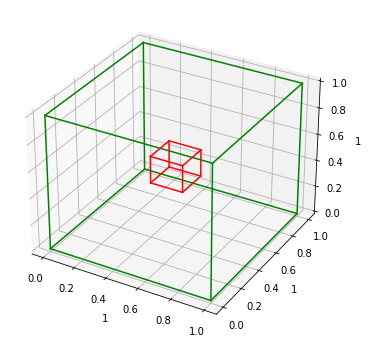

In [5]:
from itertools import product, combinations

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(132, projection='3d')
r = [0, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1] -  r[0]:
        ax.plot3D(*zip(s, e), color="green")

ax.set_xlabel('1')
ax.set_ylabel('1')
ax.set_zlabel('1')

l = [0.4, 0.6]

for s, e in combinations(np.array(list(product(l, l, l))), 2):
    if np.sum(np.abs(s-e)) == l[1] - l[0]:
        ax.plot3D(*zip(s, e), color="red")
plt.show()

<!-- axes = [1, 1, 1]

data = np.ones(axes)

l = data * 0.3


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# ax.voxels(data, alpha=1, facecolors='red', shade = True)
ax.voxels(l, alpha=0.6, facecolors='green', shade = True)

plt.show(); -->

Volume of d dimensional cube of edge l is $l^d$ ($l^3$ for 3D cube) and this cube contains k data points($R^d$ real data points d dimensional) `uniformly distributed` out of n.

\begin{align}
    \frac{l^d}{1^d} &\approx \frac{k}{n} \\
    l &\approx \big(\frac{k}{n} \big)^{\frac{1}{d}}
    \\
    \text{let } & k=10, n=1000 \\
    l &\approx \big( \frac{1}{100} \big)^{\frac{1}{d}}
\end{align}

In [6]:
x = []
for i in [2, 10, 100, 1000]:
    x.append([i, (1/100)**(1/i)])
    
pd.DataFrame(x, columns=['l', 'd'])

,l,d
0,2,0.100000
1,10,0.630957
2,100,0.954993
3,1000,0.995405


## Implementation

In [7]:
def generate_sparse_matrix(n_rows, n_cols, sparsity):

    # Number of zeros in the matrix
    num_zeros = int(n_rows * n_cols * sparsity)

    # Generate a flat array of ones and zeros
    flat_array = np.concatenate((np.ones(n_rows * n_cols - num_zeros), np.zeros(num_zeros)))

    # Shuffle the flat array randomly
    np.random.shuffle(flat_array)

    # Reshape the flat array into the desired matrix shape
    binary_matrix = np.reshape(flat_array, (n_rows, n_cols))
    
    return binary_matrix

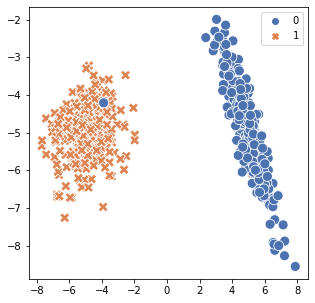

In [134]:
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_classes=2, class_sep=5, scale=1.0,
                               n_clusters_per_class=1, random_state=10)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax1, palette='deep', s=100)
plt.show()


In [127]:
n_samples = 500
n_features = [2, 10, 100, 1000, 10000, 20000]
distances = []
class0_test_distances = []
class1_test_distances = []
class0_within_distances = []
class1_within_distances = []
class0_class1_distances = []
sparse_points = []

for i in n_features:
    
    X, y = make_classification(n_samples=n_samples, n_features=i, n_redundant=0, n_classes=2, class_sep=5, scale=1.0,
                               n_clusters_per_class=1, random_state=10)
        
    sparse_matrix = generate_sparse_matrix(n_samples, i, 0.01)
    X = X * sparse_matrix
    
    sparse_points.append((n_samples * i) - sparse_matrix.sum())
    
    class1_idxs = np.where(y == 1)[0]
    class0_idxs = np.where(y == 0)[0]
    min_len = min(class0_idxs.shape[0], class1_idxs.shape[0])

    # test_point = np.zeros((1, X.shape[1])) 
    test_point = X.mean(axis=0) 
    
    class0_test_distances.append(minkowski_distance(test_point, X[class0_idxs], p=2))
    class1_test_distances.append(minkowski_distance(test_point, X[class1_idxs], p=2))
    
    random_idxs_1 = np.random.randint(0, min_len, size=np.ceil(n_samples * 0.7).astype('int'))
    random_idxs_2 = np.random.randint(0, min_len, size=np.ceil(n_samples * 0.7).astype('int'))
    
    class0_within_distances.append(minkowski_distance(X[class0_idxs][random_idxs_1], X[class0_idxs][random_idxs_2], p=2))
    class1_within_distances.append(minkowski_distance(X[class1_idxs][random_idxs_1], X[class1_idxs][random_idxs_2], p=2))
    class0_class1_distances.append(minkowski_distance(X[class0_idxs][random_idxs_1], X[class1_idxs][random_idxs_2], p=2))

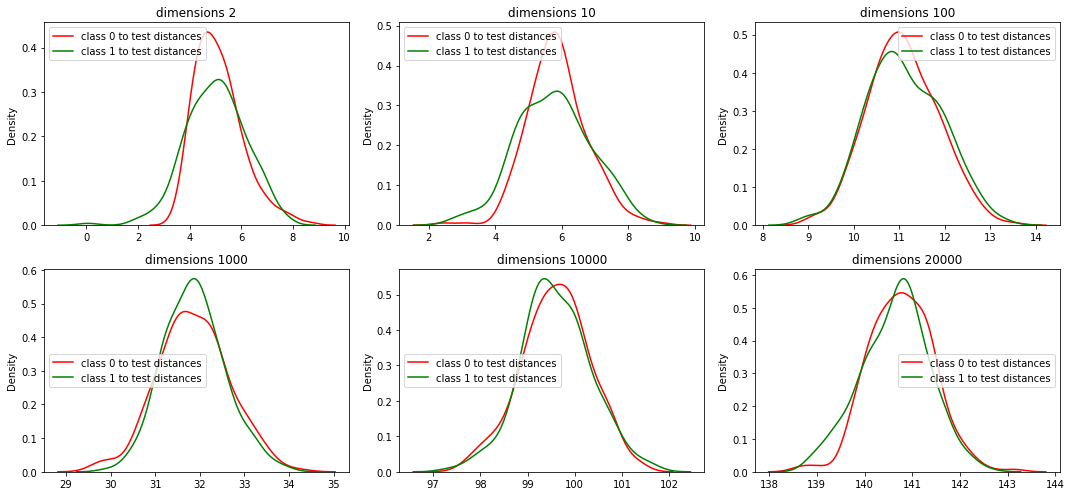

In [128]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()

for idx in range(len(n_features)):
    sns.kdeplot(class0_test_distances[idx], color='r', ax=ax[idx], label='class 0 to test distances')
    sns.kdeplot(class1_test_distances[idx], color='g', ax=ax[idx], label='class 1 to test distances')
    
    ax[idx].legend()
    ax[idx].set_title(f"dimensions {n_features[idx]}")
    
plt.tight_layout()
plt.show()

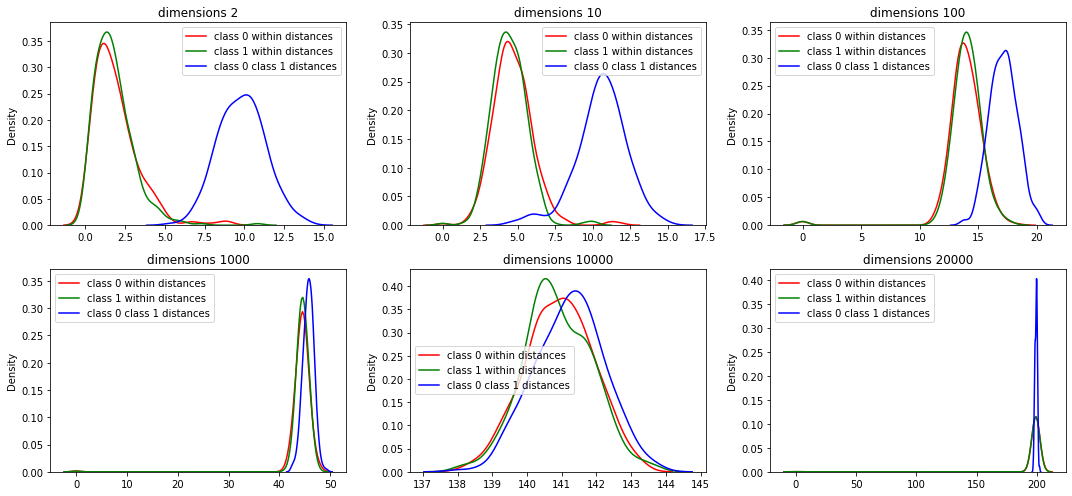

In [129]:

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()

for idx in range(len(n_features)):
    sns.kdeplot(class0_within_distances[idx], color='r', ax=ax[idx], label='class 0 within distances')
    sns.kdeplot(class1_within_distances[idx], color='g', ax=ax[idx], label='class 1 within distances')
    sns.kdeplot(class0_class1_distances[idx], color='b', ax=ax[idx], label='class 0 class 1 distances')
    
    ax[idx].set_title(f"dimensions {n_features[idx]}")
    
    ax[idx].legend()
    
plt.tight_layout()
plt.show()